# Basic Imports

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


## Download Dataset

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2021-12-14 13:48:33.444555: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /Users/psaxena/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2021-12-14 13:49:49.192569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels    = []
testing_sentences  = []
testing_labels     = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

2021-12-14 13:49:57.572863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
sequences  = tokenizer.texts_to_sequences(training_sentences)
padded     = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded    = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 10
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 1.0385e-04 - accuracy: 1.0000 - val_loss: 0.8428 - val_accuracy: 0.8307
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 6.4792e-05 - accuracy: 1.0000 - val_loss: 0.8799 - val_accuracy: 0.8309
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 4.0632e-05 - accuracy: 1.0000 - val_loss: 0.9170 - val_accuracy: 0.8304
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 2.5699e-05 - accuracy: 1.0000 - val_loss: 0.9539 - val_accuracy: 0.8295
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 1.6354e-05 - accuracy: 1.0000 - val_loss: 0.9851 - val_accuracy: 0.8305
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 1.0317e-05 - accuracy: 1.0000 - val_loss: 1.0228 - val_accuracy: 0.8300
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 6.5862e-06 - accuracy: 1.0000 - val_loss: 1.0557 -

In [20]:
import os
import sys
script_path=os.environ.get('DirForPoolScripts')
print(script_path)
sys.path.append(script_path)

/Users/psaxena/Documents/weitebildung/tensorflow-developer-zertificate-coursera/pool_common_scripts


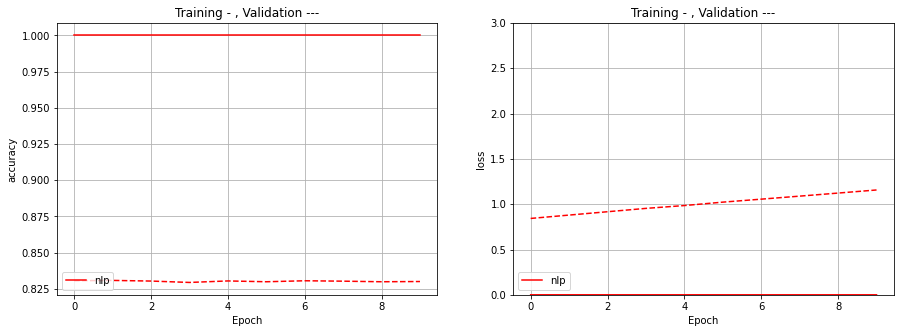

In [24]:
from ploting_script import plot_n_model
plot_n_model(num_history=1, name_history=[history], label_list=["nlp"], ylim_low=0, ylim_high=3)

In [9]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [10]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [11]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [12]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]
